# Estimating the Flare Rate for TIC 272272592
___ 

### 1.0 - Loading Full-Cadence Lightcurve Data

In [1]:
import os, sys
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.table import Table
from lightkurve.search import search_lightcurve

plt.rcParams['font.size'] = 20
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20


In [2]:
target_id = 272272592 # 
search_result = lk.search_lightcurve(f'tic {target_id}', author='SPOC')
sector = [s.split(" ")[-1] for s in search_result.mission] # available sectors

In [3]:
search_result

SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   272272592      0.0
  1 TESS Sector 15 2019   SPOC     120   272272592      0.0

In [4]:
LC = [search_lightcurve(target=f'tic {target_id}', mission='TESS', sector=f"{int(ss)}",
                        author='SPOC').download() for ss in sector]
LC = [llc.remove_nans() for llc in LC]

Text(0.5, 1.0, 'Stiched lightcurve TIC 272272592')

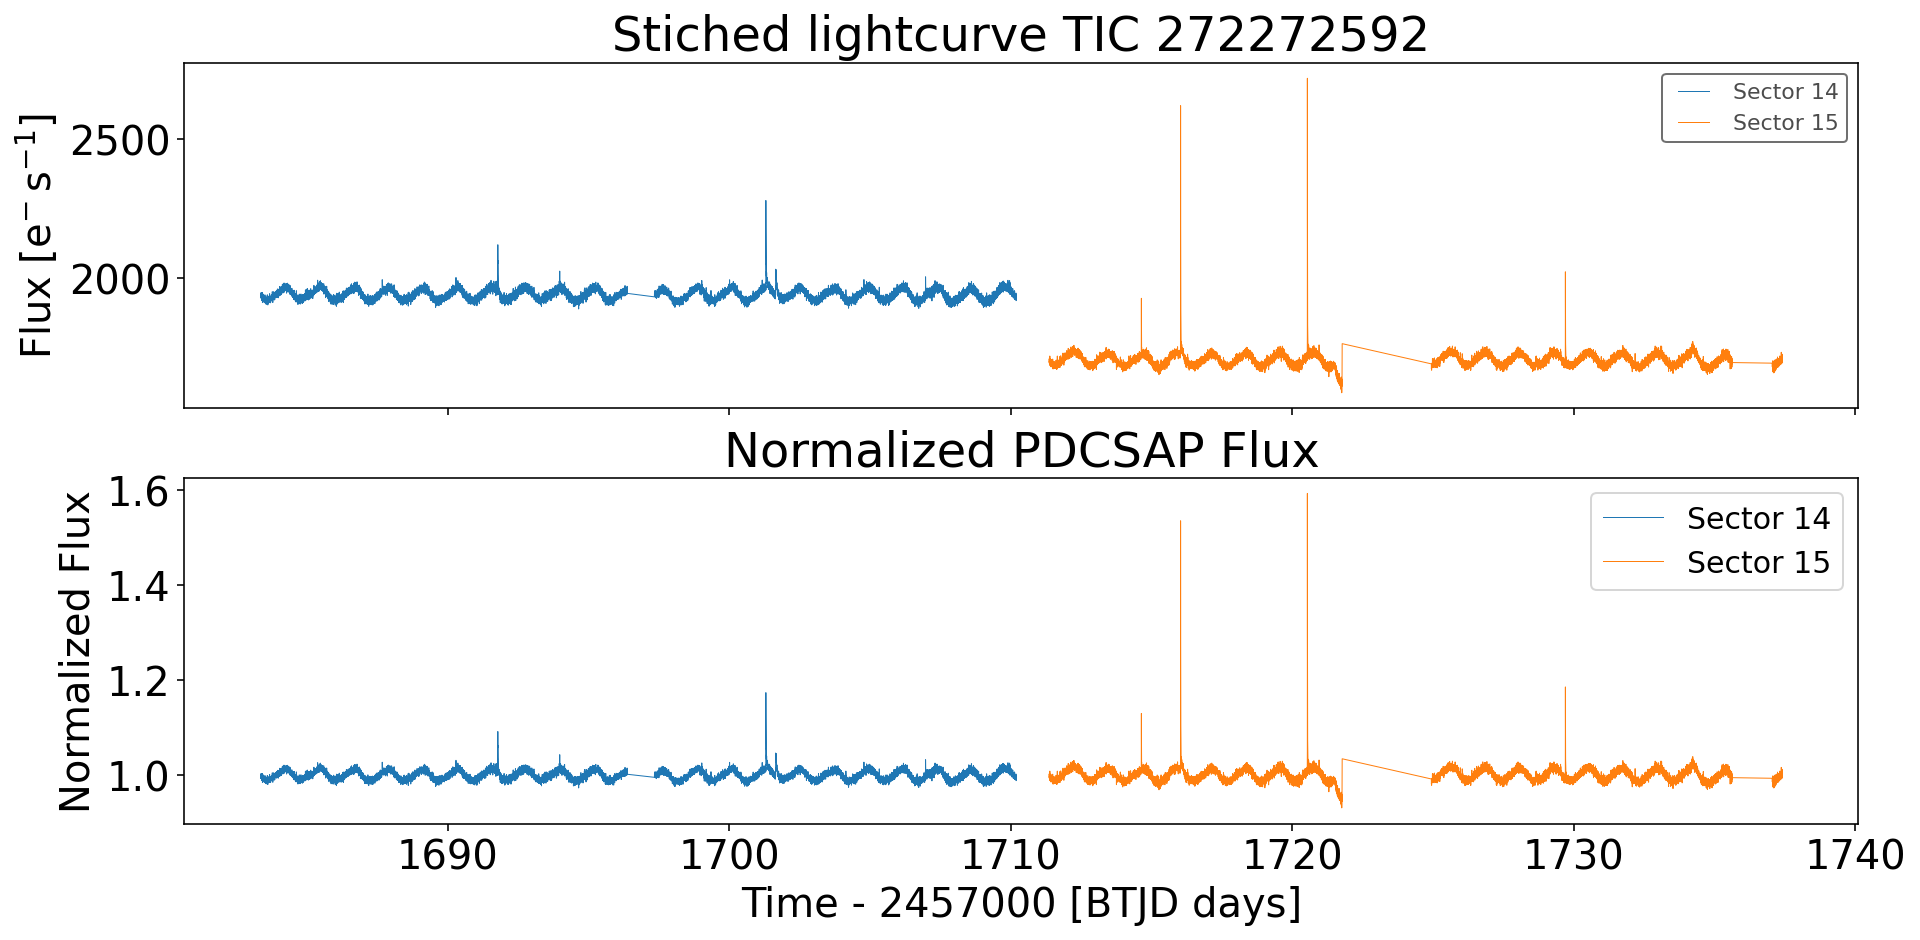

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,7), sharex=True)
for i in range(len(LC)):
    LC[i].plot(ax=ax[0], label=f"Sector {sector[i]}", xlabel='')
    LC[i].normalize().plot(ax=ax[1], label=f"Sector {sector[i]}", title='HEEEE')

    
plt.legend(fontsize=15)
ax[1].set_title("Normalized PDCSAP Flux")
ax[0].set_title(f"Stiched lightcurve TIC {target_id}")

In [6]:
def stich_lcs(lc_list, mode='raw'):
    """Function retuns stiched numpy arrays (i.e values) from each sector.
    
    Input: 
    ------
    lc_list (list): list of lightkurve targets
    mode (str): default mode is raw where it will return the flux in e-/s units. Normalized will normalize the lc to 1
    """
    
    
    if mode=='raw':
        return (np.concatenate([lc_list[j].time.value for j in range(len(lc_list))]),
    np.concatenate([lc_list[j].flux.value for j in range(len(lc_list))]),
    np.concatenate([lc_list[j].flux_err.value for j in range(len(lc_list))]))
    
    elif mode=='normalized':
        return (np.concatenate([lc_list[j].normalize().time.value for j in range(len(lc_list))]),
    np.concatenate([lc_list[j].normalize().flux.value for j in range(len(lc_list))]),
    np.concatenate([lc_list[j].normalize().flux_err.value for j in range(len(lc_list))]))
    
    

In [7]:
# Final lightcurve parameters in numpy arrays 
time0, flux0, flux_err0 = stich_lcs(LC, mode='raw') # raw counts
time, flux, flux_err = stich_lcs(LC, mode='normalized')# normalized

## Flare Identification Using `Stella`

In [8]:
sys.path.insert(1, '/Users/andytzanidakis/stella/')
import stella

In [9]:
def predict_flares(data_time, data_flux, data_flux_err, targ_id, ensembling=True, model_index=0, flare_thesh_prob=0.75, out_dir='.'):
    """This function will take the the light curve data (i.e time, flux, and flux_err)
    and using stella, it will return an astropy.table containing the identified flares given 
    a flare_threshold_probability parameter. 
    
    ensembling: True (will combine all available models via stella.DownloadSets()) trained on TESS data via
    
                If ensembling==False, function will use model index. Current available trained models:
                    0) .stella/models/hlsp_stella_tess_ensemblemodel_s004_tess_v0
                    1) .stella/models/hlsp_stella_tess_ensemblemodel_s005_tess_v0
                    2) .stella/models/hlsp_stella_tess_ensemblemodel_s018_tess_v0
                    3) .stella/models/hlsp_stella_tess_ensemblemodel_s028_tess_v0
                    4) .stella/models/hlsp_stella_tess_ensemblemodel_s029_tess_v0
                    5) .stella/models/hlsp_stella_tess_ensemblemodel_s038_tess_v0
                    6) .stella/models/hlsp_stella_tess_ensemblemodel_s050_tess_v0
                    7) .stella/models/hlsp_stella_tess_ensemblemodel_s077_tess_v0
                    8) .stella/models/hlsp_stella_tess_ensemblemodel_s078_tess_v0
                    9) .stella/models/hlsp_stella_tess_ensemblemodel_s080_tess_v0
    
    flare_thresh_prob (float): Flare rate proability treshold, range from >0 to 
    out_dir (str): output directory. Deafult is '.'
    """
    # Define CNN via Stella
    cnn = stella.ConvNN(output_dir='.')
    
    # Download trained TESS models - Feinstein et al. (2020)
    ds = stella.DownloadSets()
    ds.download_models()
    my_models = ds.models # list of all models
    
    if ensembling: 
        # ensembling will combine all models and remove duplicate identified flares
        my_flare_table = Table(names=('Target_ID', 'tpeak', 'amp', 'ed_s', 'rise', 'fall', 'prob')) # final table
        for i in range(len(my_models)):
            cnn.predict(modelname=my_models[i],
                   times=data_time,
                    fluxes=data_flux,
                    errs=data_flux_err)
            
            # Fit flares
            fit_flares = stella.FitFlares(id=[targ_id],
                                      time=[data_time],
                                      flux=[data_flux], 
                                      flux_err=[data_flux_err],
                                      predictions=[cnn.predictions[0]])
            
            fit_flares.identify_flare_peaks(threshold=flare_thesh_prob) # identify flares
            
            f_table0 = fit_flares.flare_table # flare table
            
            for j in range(len(f_table0)): # append each entry to final table
                my_flare_table.add_row(f_table0[j])
        
        # return the merged tables by only those with unique tpeak
        return my_flare_table[np.unique(my_flare_table['tpeak'], return_index=True)[1]]       
        
    else: 
        # Use the model_index selection for a single model
        cnn.predict(modelname=my_models[model_index],
                   times=data_time,
                    fluxes=data_flux,
                    errs=data_flux_err)
        
        # Fit flares
        fit_flares = stella.FitFlares(id=[targ_id],
                                      time=[data_time],
                                      flux=[data_flux], 
                                      flux_err=[data_flux_err],
                                      predictions=[cnn.predictions[0]])
        
        fit_flares.identify_flare_peaks(threshold=flare_thesh_prob) # identify flares
        
        return fit_flares.flare_table

### Comparing Stellar Flare Rates for `ensamble` vs singular models using the probability threshold parameters

#### Conclusions: 

- Is is likely that `ensembling` of models can identify more low-amplitude solar flares
- The parameter `flare_thresh_prob` I have found to give optimal results around 0.5 to 0.75

In [10]:
prob_step = np.linspace(0.1, 0.99, 20)

# how many falres do we get as we go from softer to harder probability criteria
nn = [len(predict_flares(time, flux, flux_err, LC[0].targetid,
                         ensembling=True, flare_thesh_prob=p)) for p in prob_step]

nn0 = [len(predict_flares(time, flux, flux_err, LC[0].targetid,
                         ensembling=False,model_index=0, flare_thesh_prob=p)) for p in prob_step]

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]2021-07-07 14:23:24.552577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-07 14:23:24.553950: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanida

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.86it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.95it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.33it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


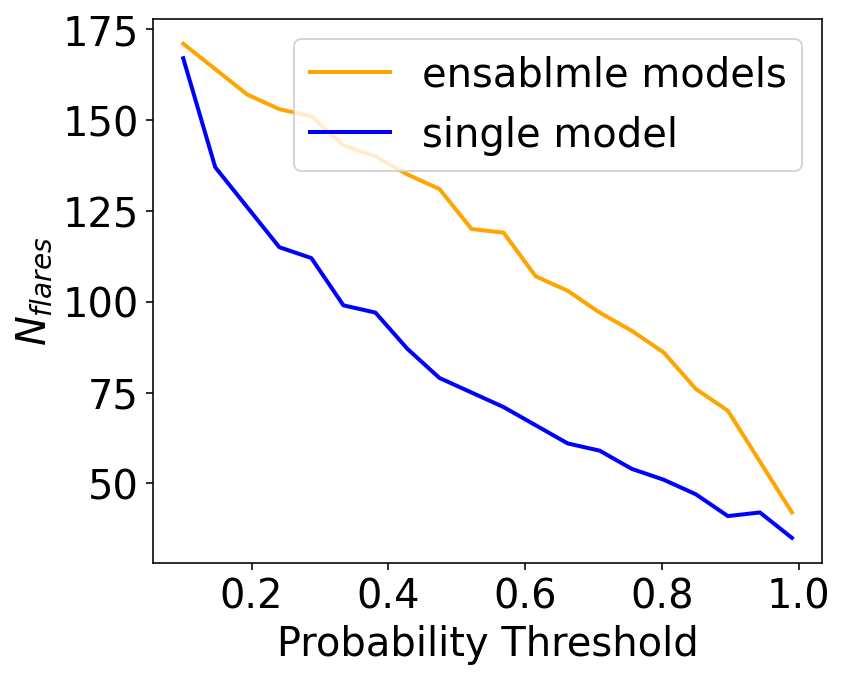

In [18]:
plt.figure(figsize=(6,5))
plt.plot(prob_step, nn, color='orange', lw=2, label='ensablmle models')
plt.plot(prob_step, nn0, color='blue', lw=2, label='single model')
plt.xlabel("Probability Threshold")
plt.ylabel("$N_{flares}$")
plt.legend()


In [19]:
# We can also mark to see where the models predict the flare location and amplitude assuming P(flare)=0.5
ftab_ens = predict_flares(time, flux, flux_err, LC[0].targetid,
                         ensembling=True, flare_thesh_prob=0.5)

ftab = predict_flares(time, flux, flux_err, LC[0].targetid,
                         ensembling=False, flare_thesh_prob=0.5)

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


Text(0.5, 1.0, 'TIC 272272592 S14 + S15 Solar Flare Identification Ensembling vs. Single Model')

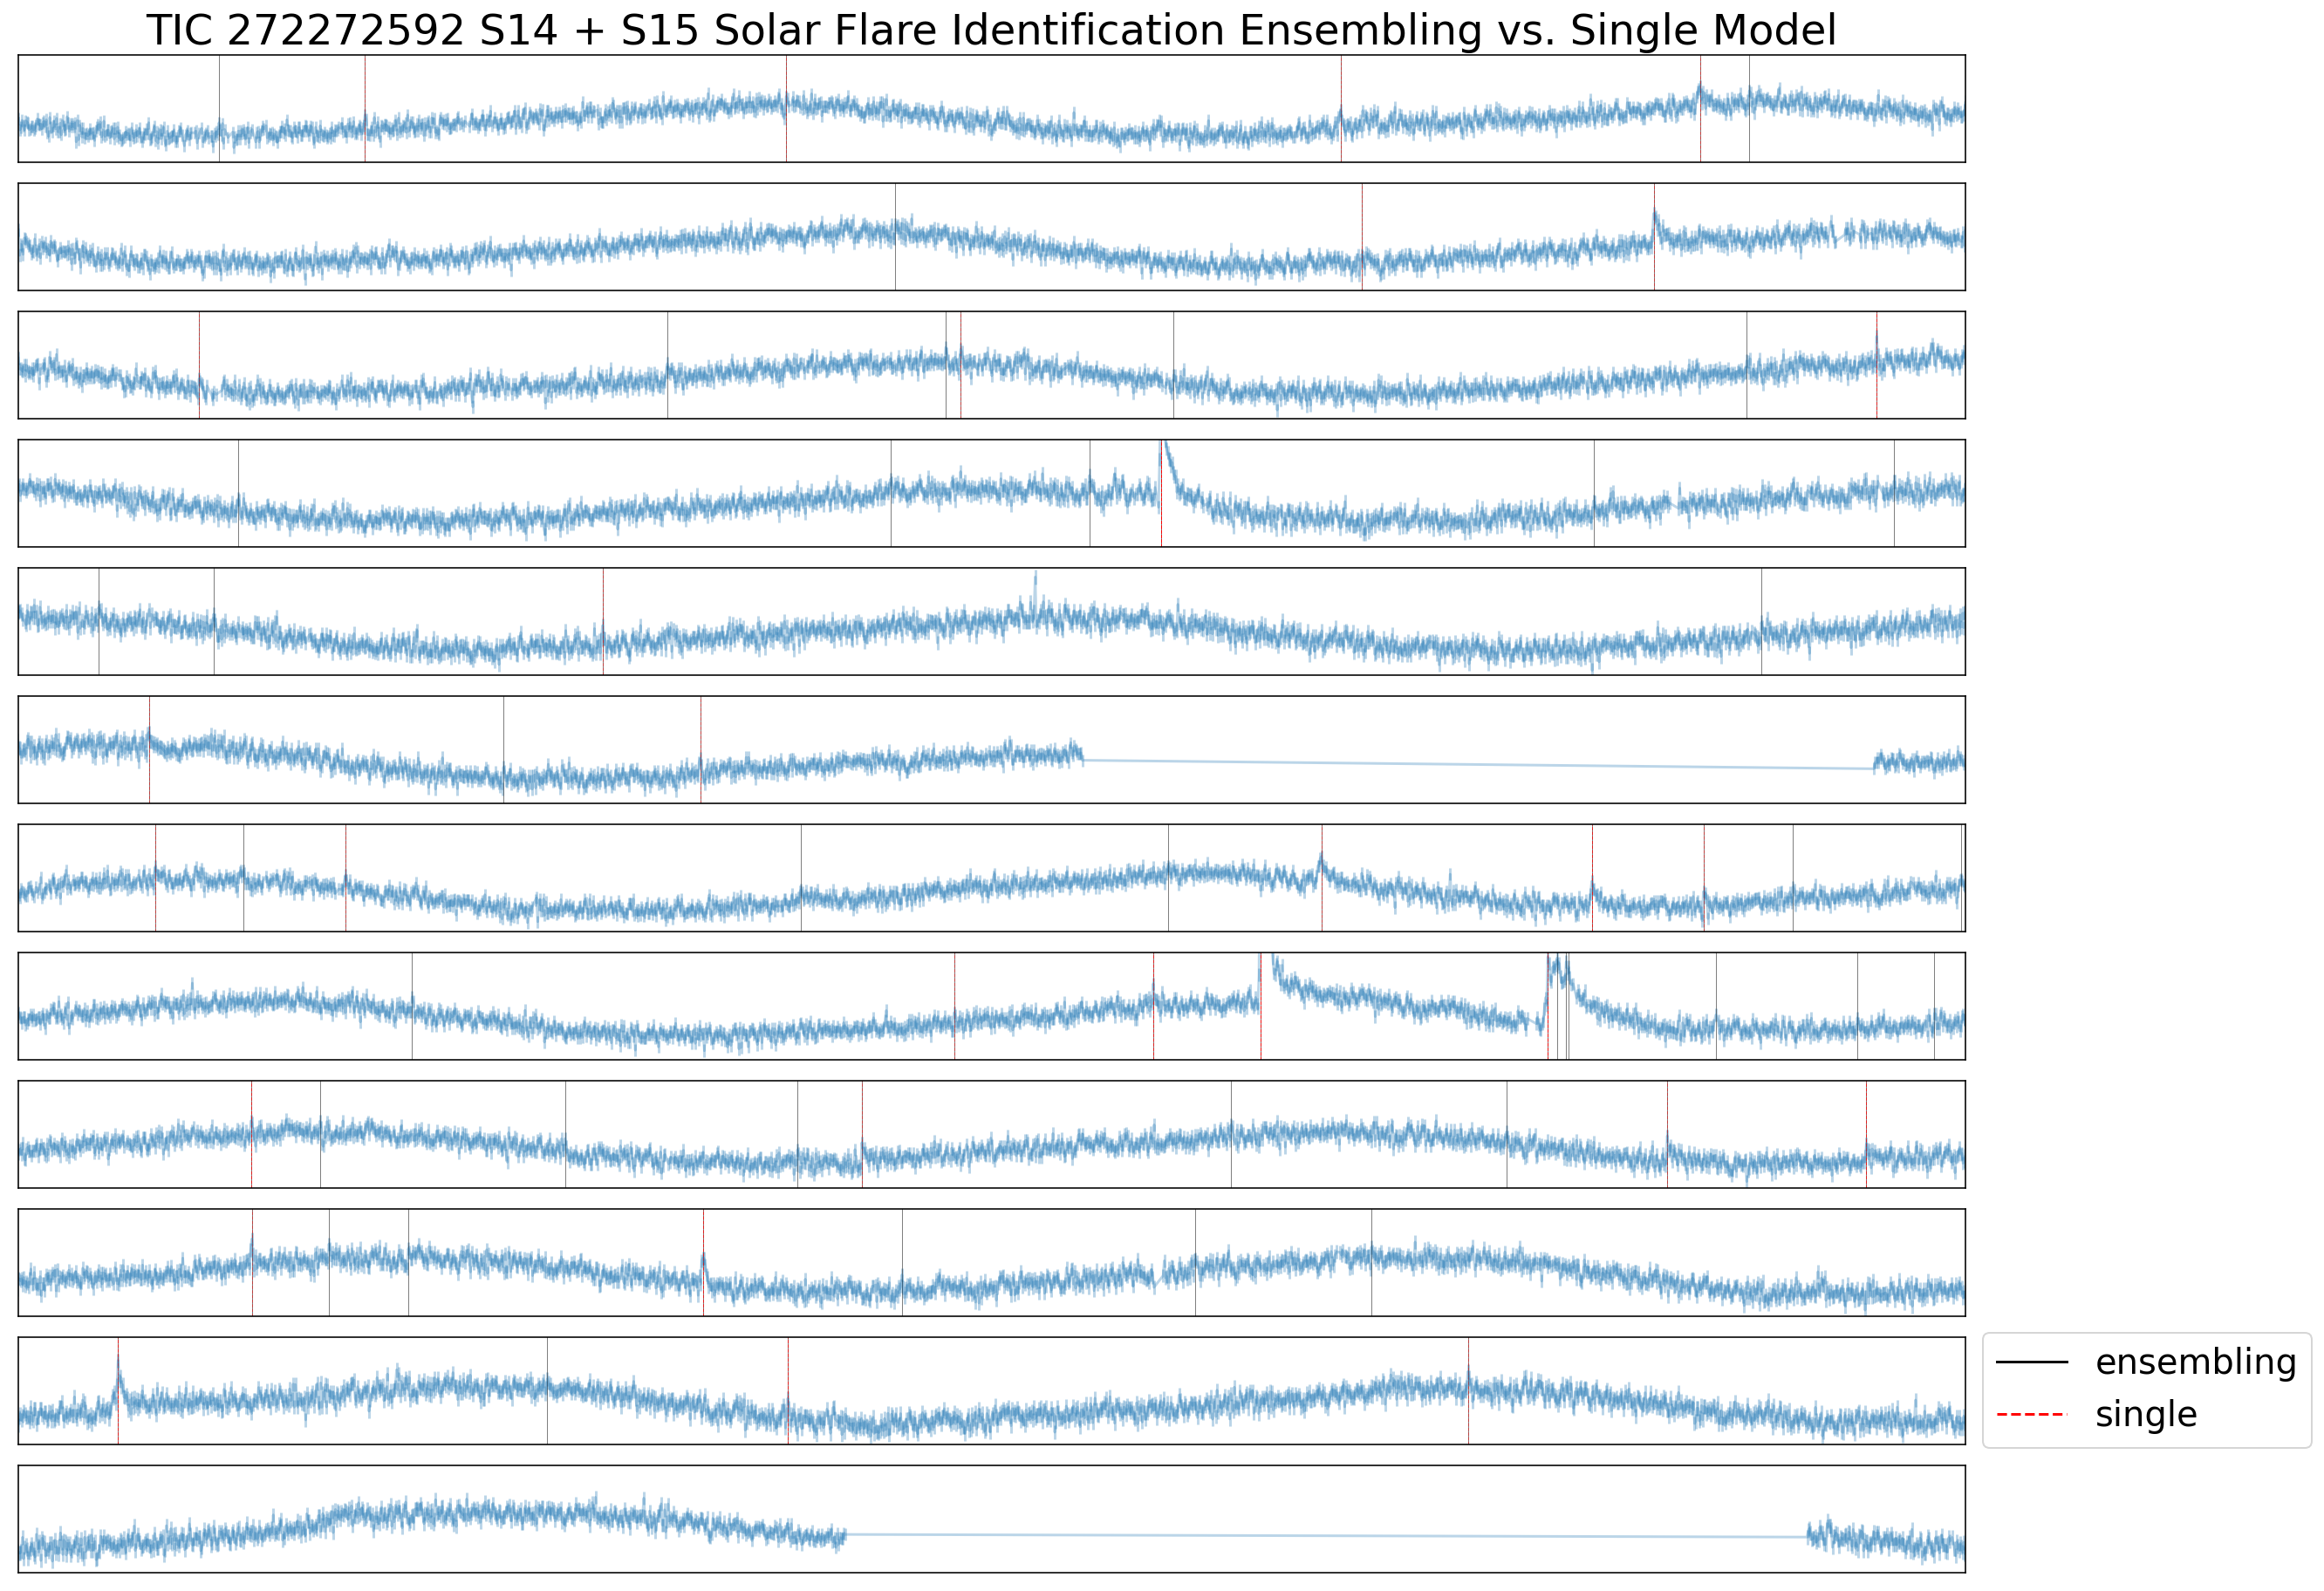

In [46]:
fig, ax = plt.subplots(nrows=12, figsize=(20,16))
xx = np.linspace(min(time), max(time), 12*2)
for i in range(12):
    ax[i].errorbar(time, flux, yerr=flux_err, fmt='-', alpha=0.3)
    ax[i].set_xlim(xx[i], xx[i+1])
    ax[i].set_ylim(0.97, 1.05)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    for j in range(len(ftab_ens)):
        ax[i].axvline(ftab_ens['tpeak'][j], color='k', lw=0.5, alpha=0.5)
        
    for k in range(len(ftab)):
        ax[i].axvline(ftab['tpeak'][k], color='red', lw=0.5, alpha=0.5, ls='--')
plt.plot(0,0, color='k', label='ensembling')
plt.plot(0,0, color='red', label='single', ls='--')
plt.legend(bbox_to_anchor=(1,1))
ax[0].set_title("TIC 272272592 S14 + S15 Solar Flare Identification Ensembling vs. Single Model")

## Calculating the Cumulitive Distributions Flare Distribution (CDFF)
___ 
- We will be operating with the ensembling of all models 

In [228]:
ftab_ens = predict_flares(time, flux, flux_err, LC[0].targetid,
                         ensembling=True, flare_thesh_prob=0.5)

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                                                  | 0/1 [00:00<?, ?it/s]/Users/andytzanidakis/stella/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|                                   

In [229]:
import numpy as np
from astropy.modeling.models import Gaussian2D


def FFD(ED, TOTEXP=1., Lum=30., fluxerr=0., dur=[], logY=True, est_comp=False):
    '''
    Given a set of stellar flares, with accompanying durations light curve properties,
    compute the reverse cumulative Flare Frequency Distribution (FFD), and
    approximate uncertainties in both energy and rate (X,Y) dimensions.
    
    This diagram can be read as measuring the number of flares per day at a
    given energy or larger.
    
    Not a complicated task, just tedious.
    
    Y-errors (rate) are computed using Poisson upper-limit approximation from
    Gehrels (1986) "Confidence limits for small numbers of events in astrophysical data", https://doi.org/10.1086/164079
    Eqn 7, assuming S=1.
    
    X-errors (event energy) are computed following Signal-to-Noise approach commonly
    used for Equivalent Widths in spectroscopy, from
    Vollmann & Eversberg (2006) "Astronomische Nachrichten, Vol.327, Issue 9, p.862", https://dx.doi.org/10.1002/asna.200610645
    Eqn 6.
    
    Parameters
    ----------
    ED : array of equivalent duration
    TOTEXP : total duration of observations, in days (max(time)-min(time))
    Lum : the log luminosity of the star
    fluxerr : the average flux errors of your data (in relative flux units!)
    dur : array of flare durations.
    logY : if True return Y-axis (and error) in log rate (Default: True)
    est_comp : estimate incompleteness using histogram method, scale Y errors?
        (Default: True)
    
    Returns
    -------
    ffd_x, ffd_y, ffd_xerr, ffd_yerr
    X coordinate always assumed to be log_10(Energy)
    Y coordinate is log_10(N/Day) by default, but optionally is N/Day
    Upgrade Ideas
    -------------
    - More graceful behavior if only an array of flares and a total duration are
        specified (i.e. just enough to make ffd_x, ffd_y)
    - Better propogation of specific flux errors in the light curve, rather than
        average error used
    - Include detrending errors? (e.g. from a GP)
    - Asymmetric Poisson errors?
    - Better handling of incompleteness?
    '''
    # REVERSE sort the flares in energy
    ss = np.argsort(np.array(ED))[::-1]
    ffd_x = np.log10(ED[ss]) + Lum

    Num = np.arange(1, len(ffd_x)+1)
    ffd_y = Num / TOTEXP

    # approximate the Poisson Y errors using Gehrels (1986) eqn 7
    Perror = np.sqrt(Num + 0.75) + 1.0
    ffd_yerr = Perror / TOTEXP

    # estimate completeness using the cumulative distribution of the histogram
    if est_comp:
        # make very loose guess at how many bins to choose
        nbin = int(np.sqrt(len(ffd_x)))
        if nbin < 10:
            nbin=10 # but use at least 10 bins

        # make histogram of the log(energies)
        hh, be = np.histogram(ffd_x, bins=nbin, range=[np.nanmin(ffd_x), np.nanmax(ffd_x)])
        hh = hh/np.nanmax(hh)
        
        # make cumulative distribution of the histogram, scale to =1 at the hist peak
        cc = np.cumsum(hh)/np.sum(hh[0:np.argmax(hh)])
        be = (be[1:]+be[0:-1])/2
        
        # make completeness = 1 for energies above the histogram peak
        cc[np.argmax(hh):] = 1
        
        # interpolate the cumulative histogram curve back to the original energies
        ycomp = np.interp(ffd_x, be, cc)
        
        # scale the y-errors by the completeness factor (i.e. inflate small energy errors)
        ffd_yerr = ffd_yerr / ycomp

    if logY:
        # transform FFD Y and Y Error into log10
        ffd_yerr = np.abs(ffd_yerr / np.log(10.) / ffd_y)
        ffd_y = np.log10(ffd_y)

    # compute X uncertainties for FFD
    if len(dur)==len(ffd_x):

        # assume relative flux error = 1/SN
        S2N = 1/fluxerr
        # based on Equivalent Width error
        # Eqn 6, Vollmann & Eversberg (2006) Astronomische Nachrichten, Vol.327, Issue 9, p.862
        ED_err = np.sqrt(2)*(dur[ss]*86400. - ED[ss])/S2N
        ffd_xerr = np.abs((ED_err) / np.log(10.) / ED[ss]) # convert to log
    else:
        # not particularly meaningful, but an interesting shape. NOT reccomended
        print('Warning: Durations not set. Making bad assumptions about the FFD X Error!')
        ffd_xerr = (1/np.sqrt(ffd_x)/(np.nanmax(ffd_x)-np.nanmin(ffd_x)))

    return ffd_x, ffd_y, ffd_xerr, ffd_yerr


def FlareKernel(x, y, xe, ye, Nx=100, Ny=100, xlim=[], ylim=[], return_axis=True):
    '''
    Use 2D Gaussians (from astropy models) to make a basic kernel density,
    with errors in both X and Y considered. Turn into a 2D "image"
    Upgrade Ideas
    -------------
    It's slow. Since Gaussians are defined analytically, maybe this could be
    re-cast as a single array math opperation, and then refactored to have the
    same fit/evaluate behavior as KDE functions.  Hmm...
    '''

    if len(xlim) == 0:
        xlim = [np.nanmin(x) - np.nanmean(xe), np.nanmax(x) + np.nanmean(xe)]
    if len(ylim) == 0:
        ylim = [np.nanmin(y) - np.nanmean(ye), np.nanmax(y) + np.nanmean(ye)]

    xx,yy = np.meshgrid(np.linspace(xlim[0], xlim[1], Nx),
                        np.linspace(ylim[0], ylim[1], Ny), indexing='xy')
    dx = (np.max(xlim)-np.min(xlim)) / (Nx-1)
    dy = (np.max(ylim)-np.min(ylim)) / (Ny-1)

    im = np.zeros_like(xx)

    for k in range(len(x)):
        g = Gaussian2D(amplitude=1/(2*np.pi*(xe[k]+dx)*(ye[k]+dy)),
                       x_mean=x[k], y_mean=y[k], x_stddev=xe[k]+dx, y_stddev=ye[k]+dy)
        tmp = g(xx,yy)
        if np.isfinite(np.sum(tmp)):
            im = im + tmp

    if return_axis:
        return im, xx, yy
    else:
        return im

In [317]:
x, y, xe, ye = FFD(ftab_ens['ed_s'], Lum=31,
                   dur=[ftab_ens['rise']+ftab_ens['fall']],
                fluxerr=np.median(flux_err)/np.median(flux), TOTEXP=max(time)-min(time))

im, xx, yy = FlareKernel(x,y,xe,ye)

Text(0.5, 1.0, 'TIC 272272592 Sector: 14, 15')

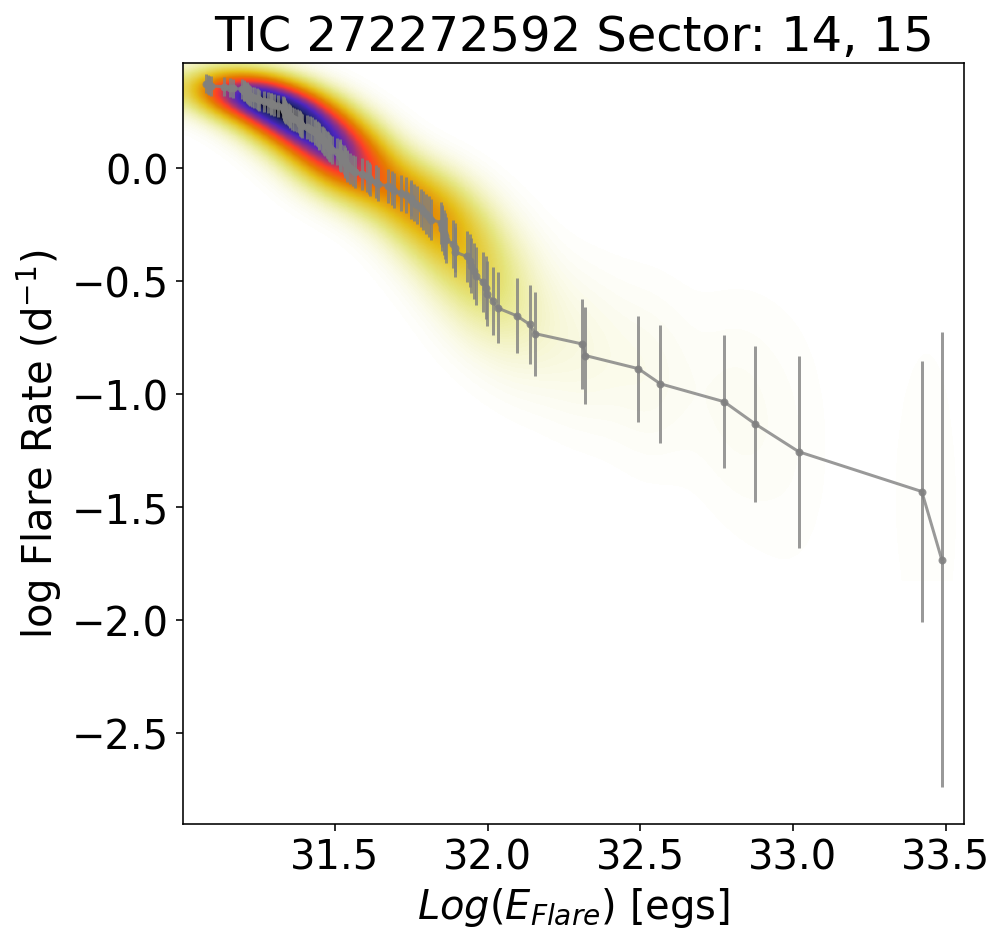

In [318]:
import matplotlib
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

ax.imshow(im, cmap='CMRmap_r', extent=(np.min(xx), np.max(xx), np.min(yy),  np.max(yy)), origin='lower',
          interpolation='gaussian', aspect='auto')
ax.errorbar(x, y, yerr=ye, color='gray', fmt='.-', alpha=0.8)
ax.set_xlabel("$Log$($E_{Flare}$) [egs]")
ax.set_ylabel("log Flare Rate (d$^{-1}$)")
ax.set_title("TIC 272272592 Sector: 14, 15")